# Implementing Faster R-CNN

The objective of this activity is to implement the main parts of the Faster R-CNN algorithm. We'll use pre-trained weights to guide and facilitate the process, and implement all the stages one by one.

We've tried to keep code in the notebooks to a minimum, mainly data manipulation and visualization, to make it easy enough to follow. All accompanying code is under the `workshop` Python package.

After some introductory code, the notebook will continue as follows:
* Playing with a **pre-trained Resnet** to obtain features out of an image.
* Generate regions of interest by implementing the **Region Proposal Network** detailed in [1].
* Prepare this regions to be fed to the second stage, by applying **RoI pooling**.
* Classify and refine said networks by passing them through an **R-CNN**, as detailed in [2].

We'll present you with stubs for the different functions required and your task will be to fill them in.

Note that, due to time constraints, we won't actually implement anything relating to training the model itself. We'll be focusing on the required machinery for inference, and give some pointers on what's missing to train it from scratch.

* [1] Ren, Shaoqing, et al. *Faster R-CNN: Towards real-time object detection with region proposal networks.*
* [2] Girshick, Ross. *Fast R-CNN.*

---
# The basics
We'll start with some imports.

The local imports are under the `workshop` package, which you should have installed using `pip install -e workshop/` in the virtualenv you're running your notebook on. [Remove if we're going to use Azure.]

Within `workshop` we have some modules:
* `vis`: various visualization utilities to draw bounding boxes, sliders, etc.
* `image`: utilities for reading images and loading them into PIL (the imaging library).
* `resnet`: the implementation for the base network we're going to use (more on this shortly).
* `faster`: utilities and parts we won't be implementing but provide for completeness' sake.

Let's test some things to make sure everything is up and ready to go.

Start by running the following in your terminal, and then test the rest of the imports:
```bash
 $ jupyter nbextension enable --py widgetsnbextension
 ```

In [54]:
from ipywidgets import interact, Checkbox, FloatSlider, Layout

import json
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.contrib.eager as tfe

from PIL import Image


# Try to enable TF eager execution, or do nothing if running again.
try:
    tf.enable_eager_execution()
except ValueError:
    # Already executed.
    pass


# Local imports.
from workshop.faster import clip_boxes, rcnn_proposals, run_base_network, run_resnet_tail, sort_anchors
from workshop.image import open_all_images, open_image, to_image
from workshop.vis import add_rectangle, draw_bboxes, draw_bboxes_with_labels, image_grid, pager

# Notebook-specific settings.
%matplotlib inline

We'll now load some images to play with and display them below. Change which image is passed to the `to_image` function to see it in full size.

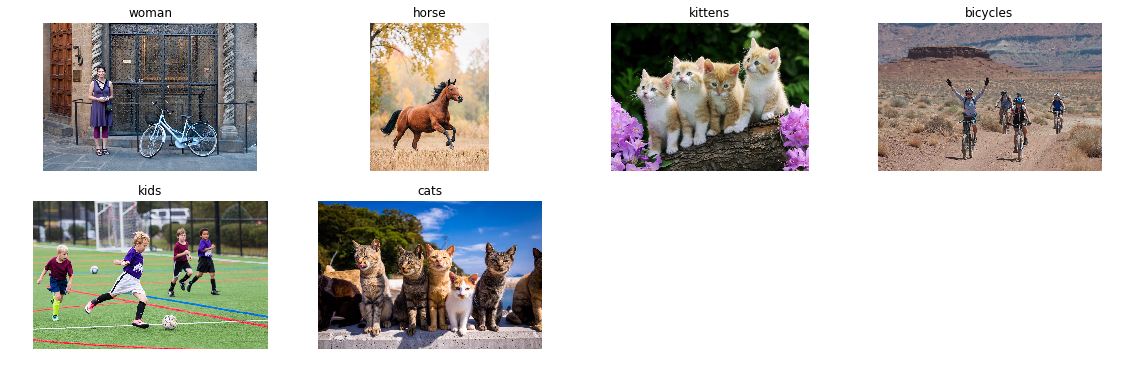

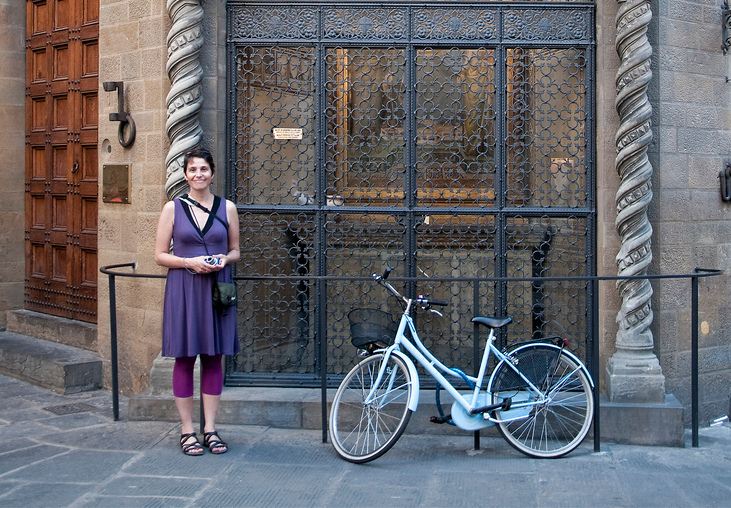

In [55]:
images = open_all_images('images/')

axes = image_grid(len(images))
for ax, (name, image) in zip(axes, images.items()):
    ax.imshow(np.squeeze(image))
    ax.set_title(name)

plt.subplots_adjust(wspace=.01)
plt.show()

image = images['woman']

# `to_image` turns a `numpy.ndarray` into a PIL image, so it's displayed by the notebook.
to_image(image)

---
# The base network: ResNet


The basis for the Faster R-CNN algorithm is to leverage a pre-trained classifier network to extract feature maps (also called *activation maps*) from the image. For this implementation, we'll be using the popular ResNet 101 [3].

We provide the implementation itself (which you can see in the `workshop.resnet` module), as well as a checkpoint with the weights (in the `checkpoint/` directory).

---

### Aside

The ResNet architecture consists of four stacked **blocks**, after which a fully-connected layer is attached. As is expected of CNNs, these blocks detect features from most simple to most complex. For this part of the algorithm, we're using the output of the **block 3**, so we get somewhat generic features. The intuition is that, if we go all the way and use block 4, we might have things that are too specific to the dataset used to pre-train the ResNet (the Imagenet dataset) and thus not as desirable for a network that wants to identify generic objects. 

---

Run the base network on different images, in order to see how the different feature maps behave. **Can you notice any particular features being detected in the activation maps?**

* [3] He, Kaiming, et al. *Deep residual learning for image recognition.*

In [56]:
with tfe.restore_variables_on_create('checkpoint/fasterrcnn'):
    feature_map = run_base_network(image)

In [57]:
@interact(page=pager(1024, 20, 'Feature map'))
def display_feature_maps(page):
    axes = image_grid(20)
    for idx, ax in enumerate(axes):
        if page * 20 + idx >= 1024:
            break
        ax.imshow(
            feature_map.numpy()[0, :, :, page * 20 + idx],
            cmap='gray', aspect='auto'
        )

    plt.subplots_adjust(wspace=.01, hspace=.01)
    plt.show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='Feature map', layout=Layout(wid…

Let's overlay the feature maps into the image themselves, so we can take a more detailed look into what feature of the image the ResNet reacts to.

See, for example:
* Feature maps 19, 22 in `cats`.
* Feature map 34, 64 in `bicycles`.
* Feature map 253 in `kids`.

In [58]:
@interact(idx=pager(1024, 1, 'Feature map index'))
def overlay_feature_map(idx):
    # Normalize the feature map so we get the whole range of colors.
    fm = (
        feature_map.numpy()[0, :, :, idx]
        / feature_map.numpy()[0, :, :, idx].max()
        * 255
    ).astype(np.uint8)
    
    # Resize the feature map without interpolation.
    fm_image = Image.fromarray(fm, mode='L').convert('RGBA')
    fm_image = fm_image.resize(image.shape[1:3][::-1], resample=Image.NEAREST)
    
    # Add some alpha to overlay it over the image.
    fm_image.putalpha(200)
    
    base_image = to_image(image)
    base_image.paste(fm_image, (0, 0), fm_image)
    
    return base_image

interactive(children=(IntSlider(value=0, continuous_update=False, description='Feature map index', layout=Layo…

This section didn't require any implementation at all, but get ready, because we're about to. The main idea here was illustrating what we mean when we say that the later layers of a classification network are **feature detectors**, reacting to particular structures in an image.

What would you do if you were to use this information to detect objects? How could you leverage the fact that we can say "there's a cat ear here!"? We're going to explore these questions in the following sections.

For now, back to the slides!

---
# Finding stuff with the Region Proposal Network

Having gone through the theory, we'll now turn our attention to implementing a **Region Proposal Network**. The idea, as we've seen, is to use the feature maps provided by the ResNet to find out **where** there might be an object located.

This is where **anchors** come into play. We'll take a grid of points over the image and consider several (15, in this case) anchors, or reference boxes, for each of them. The RPN layers themselves will then predict whether there's an object in each of these 15 boxes **and** how much we need to resize them to better fit it.

The tasks we have ahead of us are, thus:
* Get the **coordinates** $(x_{min}, y_{min}, x_{max}, y_{max})$ for each of the anchors. There are $15$ anchors and the centers will be separated by approximately $16$ pixels, so we're talking about several thousand of coordinates.
* Find out how to do the special **encoding and decoding** of coordinates described in Faster R-CNN so the RPN can predict locations in the image.
* Build the **convolutional layers** comprising the RPN and run them through different images.
* **Translate the predictions** of the RPN layer into usable proposals.

**Note**: Except in specific cases, we'll be using the convention $(x_{min}, y_{min}, x_{max}, y_{max})$ to denote a bounding box, were $(x_{min}, y_{min})$ corresponds to the top-left point and $(x_{max}, y_{max})$ the bottom right. As usual with image processing, the origin of the coordinate system, $(0, 0)$, is on the top-left of the image.

## Generating anchors

We'll get the anchor's coordinates in two steps. First we'll implement the `generate_anchors_reference` function which will return, given the anchors' settings (i.e. size, aspect ratio, scales), the coordinates for said boxes (in pixel space) assuming they're centered around (0, 0). This will give us, effectively, a $(15, 4)$ array.

Then, we'll sum those coordinates to each of the **anchor centers** of the image in the function `generate_anchors`. Given that we're using a ResNet 101, which has a downsampling factor of 16 (i.e. every point in the final feature map corresponds to a $16\times16$ region of the original image), we'll select the centers every 16 pixels in each direction.

Go on and implement `generate_anchors_reference`, and check that the output makes sense. You can try varying the anchor settings to see if it still makes sense. There are three settings for the anchors:
* `base_size`: **side length for a square anchor**, in pixels (e.g. 256). Increasing it makes the reference box cover more area of the image.
* `scales`: **scale factors** to consider taking `base_size` as reference. For instance, a scale of `2` will make the effective size `512` if base size was `256`.
* `aspect_ratios`: **aspect ratios** of the anchors, expressed as the value of `height / width`. Note that *changing the aspect ratio doesn't change the area the anchor covers*. An aspect ratio of `2` means that, for the area covered by a square anchor of of `base_size`, we should get a rectangle of twice the height than width.

In [59]:
def generate_anchors_reference(base_size, aspect_ratios, scales):
    """Generate base set of anchors to be used as reference for all anchors.

    Anchors vary only in width and height. Using the base_size and the
    different ratios we can calculate the desired widths and heights.

    Aspect ratios maintain the area of the anchors, while scales apply to the
    length of it (and thus affect it squared).

    Arguments:
        base_size (int): Base size of the base anchor (square).
        aspect_ratios: Ratios to use to generate different anchors. The ratio
            is the value of height / width.
        scales: Scaling ratios applied to length.

    Returns:
        anchors: Numpy array with shape (total_aspect_ratios * total_scales, 4)
            with the corner points of the reference base anchors using the
            convention (x_min, y_min, x_max, y_max).
    """
    
    # Tip: if you want to write vectorized code for this function, the
    # `np.meshgrid` and `np.stack` functions might be useful.
    
    # Tip: For this function, it's not necessary to use Tensorflow, as it's
    # used as a constant in the following function. Use whatever feels right
    # for you.
    
    ####
    # Fill this function below, paying attention to the docstring.
    ####
    
    scales_grid, aspect_ratios_grid = np.meshgrid(scales, aspect_ratios)
    base_scales = scales_grid.reshape(-1)
    base_aspect_ratios = aspect_ratios_grid.reshape(-1)

    aspect_ratio_sqrts = np.sqrt(base_aspect_ratios)
    heights = base_scales * aspect_ratio_sqrts * base_size
    widths = base_scales / aspect_ratio_sqrts * base_size

    # Center point has the same X, Y value.
    center_xy = 0

    # Create anchor reference.
    anchors = np.column_stack([
        center_xy - widths / 2,
        center_xy - heights / 2,
        center_xy + widths / 2,
        center_xy + heights / 2,
    ])

    ####
    
    # We sort the anchors to the value expected by our pre-trained network.
    return sort_anchors(anchors)


references = generate_anchors_reference(
    256,  # Base size.
    [0.5, 1, 2],  # Aspect ratios.
    [0.125, 0.25, 0.5, 1, 2],  # Scales.
)

print('Anchor references (real image size):')
print()
print(references)

Anchor references (real image size):

[[ -22.627417    -11.3137085    22.627417     11.3137085 ]
 [ -45.254834    -22.627417     45.254834     22.627417  ]
 [ -90.50966799  -45.254834     90.50966799   45.254834  ]
 [-181.01933598  -90.50966799  181.01933598   90.50966799]
 [-362.03867197 -181.01933598  362.03867197  181.01933598]
 [ -16.          -16.           16.           16.        ]
 [ -32.          -32.           32.           32.        ]
 [ -64.          -64.           64.           64.        ]
 [-128.         -128.          128.          128.        ]
 [-256.         -256.          256.          256.        ]
 [ -11.3137085   -22.627417     11.3137085    22.627417  ]
 [ -22.627417    -45.254834     22.627417     45.254834  ]
 [ -45.254834    -90.50966799   45.254834     90.50966799]
 [ -90.50966799 -181.01933598   90.50966799  181.01933598]
 [-181.01933598 -362.03867197  181.01933598  362.03867197]]


In [60]:
# We should have obtained 5 areas and 3 different aspect ratios in our
# anchor references.
widths = references[:, 2] - references[:, 0]
heights = references[:, 3] - references[:, 1]

aspect_ratios = np.round(heights / widths, 1)
areas = widths * heights

assert len(np.unique(areas)) == 5
assert len(np.unique(aspect_ratios)) == 3

print('Areas:', len(np.unique(areas)))
print('Aspect ratios:', len(np.unique(aspect_ratios)))

Areas: 5
Aspect ratios: 3


A good way to check if the implementation is correct is just drawing them and making sure the result makes sense. If the image is too chaotic, you can try decreasing the number of scales and aspect ratios, but do revert it back before continuing.

Remember: for scales, length is doubled, for aspect ratios, the area is maintained.

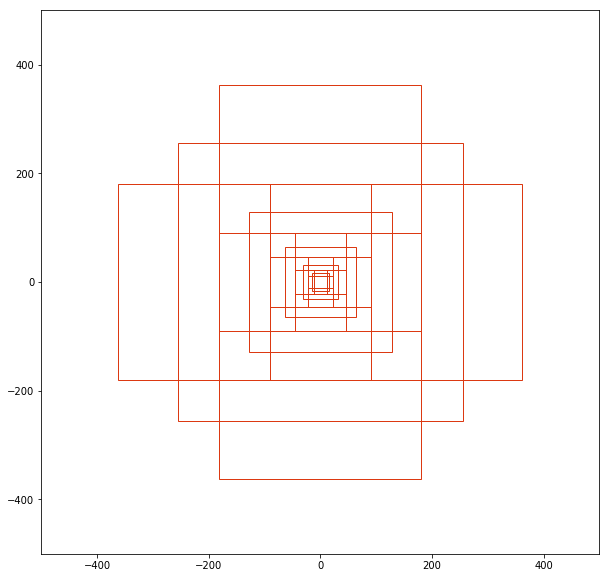

In [61]:
_, ax = plt.subplots(1, figsize=(10, 10))

ax.set_xlim([-500, 500])
ax.set_ylim([-500, 500])

for idx in range(references.shape[0]):
    add_rectangle(ax, references[idx, :])

plt.show()

And for reference, let's draw one over `image`, to see how they match. Since the anchor references are centered around $(0, 0)$, we can sum $P = (x_p, y_p)$ to get the references at $P$.

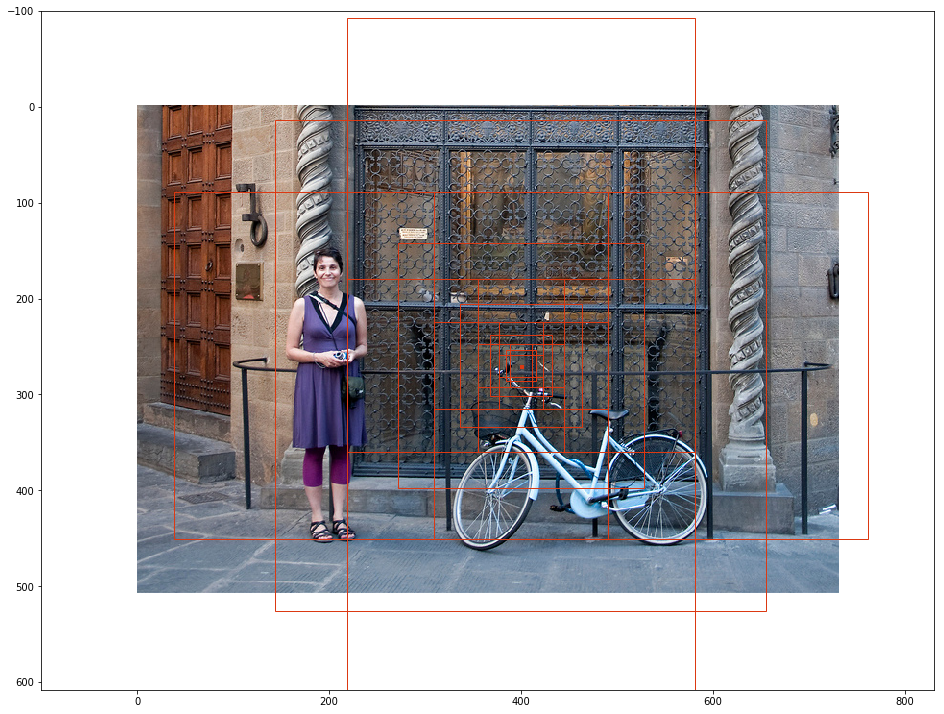

In [62]:
point = np.array([400, 270])

# Sum the point on both the *_min and the *_max parts.
references_at_point = references + np.concatenate([point, point])

_, ax = plt.subplots(1, figsize=(16, 20))
ax.imshow(to_image(image))

# Add a buffer around the image so we see the whole anchor references.
ax.set_xlim([-100, image.shape[2] + 100])
ax.set_ylim([image.shape[1] + 100, -100])

for idx in range(references_at_point.shape[0]):
    add_rectangle(ax, references_at_point[idx, :])

# Plot the reference point in use.
ax.plot(point[0], point[1], marker='s', color='#dc3912', markersize=3)

plt.show()

As you can see, the larger boxes cover quite a bit of the image, while the smaller ones will be useful for detecting very small objects.

Now, as we said before, we want the above for all **anchor centers**, which we said were going to be located every 16 pixels. For reference, the anchor centers are visualized below.

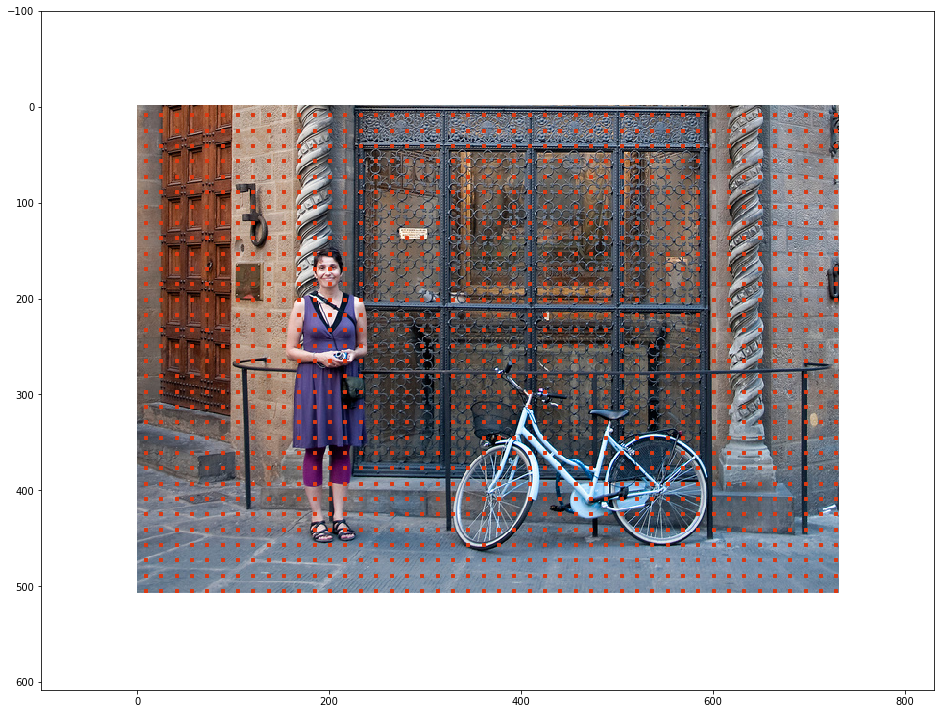

In [63]:
# This is actually defined within `run_base_network`, but for visualization
# purposes, we're defining it again.
OUTPUT_STRIDE = 16

# Print the anchor centers in use.
_, ax = plt.subplots(1, figsize=(16, 20))

ax.imshow(to_image(image))
ax.set_xlim([-100, image.shape[2] + 100])
ax.set_ylim([image.shape[1] + 100, -100])

# We start from `output_stride / 2`, as we want the points centered around
# the 16x16 region.
for x in range(OUTPUT_STRIDE // 2, image.shape[2], OUTPUT_STRIDE):
    for y in range(OUTPUT_STRIDE // 2, image.shape[1], OUTPUT_STRIDE):
        ax.plot(x, y, marker='s', color='#dc3912', markersize=3)

plt.show()

Let's wrap up this part by getting the entire list of anchors for the image. This will be done within the `generate_anchors` function.

In [102]:
# These are the anchor properties that will be used in our implementation.
# Compared to the values picked on the paper, we've added two, smaller, scales
# that help the model detect the smaller objects present in the COCO dataset.
ANCHOR_BASE_SIZE = 256
ANCHOR_RATIOS = [0.5, 1, 2]
ANCHOR_SCALES = [0.125, 0.25, 0.5, 1, 2]


def generate_anchors(feature_map_shape):
    """Generate anchors for an image.

    Using the feature map (the output of the pretrained network for an image)
    and the anchor references (generated using the specified anchor sizes and
    ratios), we generate a list of anchors.

    Anchors are just fixed bounding boxes of different ratios and sizes that
    are uniformly generated throught the image.

    Arguments:
        feature_map_shape: Shape of the convolutional feature map used as
            input for the RPN. Should be (batch, height, width, depth).

    Returns:
        all_anchors: A Tensor with the anchors at every spatial of shape
            `(feature_height, feature_width, num_anchors_per_points, 4)`
            using the (x1, y1, x2, y2) convention.
    """

    anchor_reference = generate_anchors_reference(
        ANCHOR_BASE_SIZE, ANCHOR_RATIOS, ANCHOR_SCALES
    )
    
    
    # Tip: See `tf.meshgrid`, `tf.range`, `tf.expand_dims`, `tf.transpose`
    # if doing it in a vectorized way.
    
    ####
    # Fill this function below, paying attention to the docstring.
    ####
    grid_width = feature_map_shape[2]  # width
    grid_height = feature_map_shape[1]  # height
    
    # Non-vectorized way.
    # all_anchors = np.zeros(
    #     (grid_height, grid_width, anchor_reference.shape[0], 4)
    # )
    
    # for x in range(grid_width):
    #     for y in range(grid_height):
    #         all_anchors[y, x] = (
    #             anchor_reference + np.array([x, y, x, y]) * OUTPUT_STRIDE
    #         )
    
    # return all_anchors
    
    shift_x = tf.range(grid_width) * OUTPUT_STRIDE
    shift_y = tf.range(grid_height) * OUTPUT_STRIDE
    shift_x, shift_y = tf.meshgrid(shift_x, shift_y)

    shifts = tf.stack(
        [shift_x, shift_y, shift_x, shift_y],
        axis=0
    )

    shifts = tf.transpose(shifts, [1, 2, 0])
    # Shifts now is a (H, W, 4) tensor.

    # Expand dims to use broadcasting sum.
    all_anchors = (
        anchor_reference[np.newaxis, np.newaxis, ...] +
        tf.expand_dims(shifts, axis=2)
    )
    
    ####

    return all_anchors


anchors = tf.reshape(generate_anchors(feature_map.shape), [-1, 4])

print('Anchors (real image size):')
print()
print(anchors.numpy())

Anchors (real image size):

[[-22 -11  22  11]
 [-45 -22  45  22]
 [-90 -45  90  45]
 ...
 [675 406 765 586]
 [630 315 810 677]
 [539 134 901 858]]


Let's get three or four anchors to corroborate that the results makes sense.

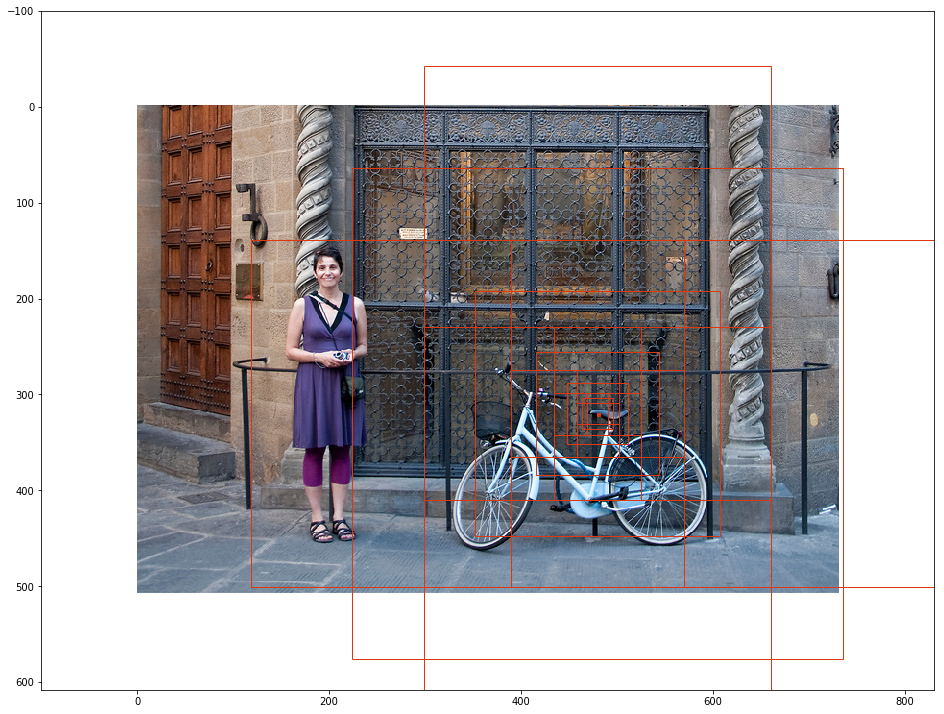

In [103]:
# Visualize the anchors. Try changing to different points of the image.
# Note that we're referring to positions in the feature map here, so the
# actual point in the image will be around `OUTPUT_STRIDE` times the value.
point = np.array([30, 20])

# Reshape back to (H, W, num_anchors, 4) so we can easily get a given point's anchors.
anchors_at_point = anchors.numpy().reshape(
    (feature_map.shape[1], feature_map.shape[2], 15, 4)
)[point[1], point[0], :, :]

_, ax = plt.subplots(1, figsize=(16, 20))

ax.imshow(to_image(image))
ax.set_xlim([-100, image.shape[2] + 100])
ax.set_ylim([image.shape[1] + 100, -100])

for idx in range(anchors_at_point.shape[0]):
    add_rectangle(ax, anchors_at_point[idx, :])

# Plot the reference point in use.
ax.plot(
    point[0] * OUTPUT_STRIDE,
    point[1] * OUTPUT_STRIDE,
    marker='s', color='#dc3912', markersize=3
)

plt.show()

With this we've finished generating the anchors that will be used by the RPN. This is, effectively, a list of $15 \times F_x \times F_y$, where $F_x, F_y$ are the feature map width and height, respectively.

## Encoding and decoding coordinates


Deep neural networks usually train and converge better when their outputs have zero mean and unit variance (and/or their intermediate values do so). Due to this, and the difficulty in predicting values in a possibly unbounded region (pixel coordinates), a special encoding is applied to the coordinates before passing them in to the network (and after getting them out).

The idea behind the encoding is to express the coordinates of a bounding box $B$ as a set of four numbers $(D_x, D_y, D_w, D_h)$ (the **deltas**) and a reference bounding box $R$. $D_x$ and $D_y$ indicate how much the center of $B$ should be moved to reach the center of $R$, normalized by the size of $R$, while $D_w$ and $D_h$ indicate how much the width and height of $B$ must be increased or decreased to reach the size of $R$ (it's actually the log of that value, as you'll see below).

For the following equations, we change from the $(x_{min}, y_{min}, x_{max}, y_{max})$ encoding to the center+dimensions encoding $(x, y, w, h)$, where $(x, y)$ are the **center coordinates**, and $(w, h)$ the **width and height**. The equations to encode $B = (x_b, y_b, w_b, h_b)$ with regard to $R = (x_r, y_r, w_r, h_r)$ are, then:

$D_x = \frac{x_b - x_r}{w_r} \quad$
$D_y = \frac{y_b - y_r}{h_r} \quad$
$D_w = log \frac{w_b}{w_r} \quad$
$D_h = log \frac{h_b}{h_r}$

The equations to decode $B = (x_b, y_b, w_b, h_b)$ given $R = (x_r, y_r, w_r, h_r)$ and deltas $D = (D_x, D_y, D_w, D_h)$ are:

$x_b = D_x w_r + x_r \quad$
$y_b = D_y h_r + y_r \quad$
$w_b = e^{D_w} w_r \quad$
$h_b = e^{D_h} h_r \quad$

We'll implement two functions here, `encode` and `decode`. While only the latter will be used, it's useful to implement both in order to understand the whole process and to make it easier to test.

In [66]:
# You might find it useful to implement the following function first in order
# to obtain the dimensions (width and height) and center of a bounding box,
# required for calculating the deltas in `encode` and `decode`.
def get_dimensions_and_center(bboxes):
    """Obtain width, height and center coordinates of a bounding box.
    
    Arugments:
        bboxes: Tensor of shape (num_bboxes, 4).
        
    Returns:
        Tuple of Tensors of shape (num_bboxes,) with the values
        width, height, center_x and center_y corresponding to each
        bounding box.
    """
    
    # Tip: Fully read the docstring above.
    # Tip: You may find the Tensorflow function `tf.split` useful.

    ####
    # Fill this function below, paying attention to the docstring.
    ####
    
    bboxes = tf.cast(bboxes, tf.float32)
    x1, y1, x2, y2 = tf.split(bboxes, 4, axis=1)
    width = x2 - x1
    height = y2 - y1

    # Calculate center of the bounding box.
    ctx = x1 + .5 * width
    cty = y1 + .5 * height
    
    ####

    return width, height, ctx, cty

In [67]:
def encode(references, bboxes):
    """Encode bounding boxes as deltas w.r.t. reference boxes.

    Arguments:
        references: Tensor of shape (num_bboxes, 4). With the same bbox
            encoding.
        bboxes: Tensor of shape (num_bboxes, 4). Having the bbox
            encoding in the (x_min, y_min, x_max, y_max) order.

    Returns:
        Tensor of shape (num_bboxes, 4) with the different
            deltas needed to transform the proposal to `references`. These
            deltas are with regards to the center, width and height of the
            two boxes.
    """
   
    ####
    # Fill this function below, paying attention to the docstring.
    ####

    (
        bboxes_width, bboxes_height, bboxes_ctx, bboxes_cty
    ) = get_dimensions_and_center(bboxes)

    (
        ref_boxes_width, ref_boxes_height, ref_boxes_ctx, ref_boxes_cty
    ) = get_dimensions_and_center(references)

    deltas_dx = (bboxes_ctx - ref_boxes_ctx) / ref_boxes_width
    deltas_dy = (bboxes_cty - ref_boxes_cty) / ref_boxes_height

    deltas_dw = tf.log(bboxes_width / ref_boxes_width)
    deltas_dh = tf.log(bboxes_height / ref_boxes_height)

    deltas = tf.concat([
        deltas_dx, deltas_dy, deltas_dw, deltas_dh
    ], axis=1)

    ####

    return deltas


# Encoding `bbox` with a `reference` having the same center should keep
# the first two deltas at zero.
ref = np.array([[0, 0, 100, 100]], dtype=np.float32)
bbox = np.array([[25, 25, 75, 75]], dtype=np.float32)
print('Same center:', encode(ref, bbox).numpy())

# Encoding `bbox` with a `reference` having the same size should keep
# the last two deltas at zero.
ref = np.array([[0, 0, 100, 100]], dtype=np.float32)
bbox = np.array([[50, 50, 150, 150]], dtype=np.float32)
print('Same size:', encode(ref, bbox).numpy())

# What other ways to check the functions can you think of?

Same center: [[ 0.         0.        -0.6931472 -0.6931472]]
Same size: [[0.5 0.5 0.  0. ]]


In [68]:
def decode(references, deltas):
    """Decode proposals by applying deltas to bboxes.
    
    Arguments:
        references: Tensor of shape (num_bboxes, 4). Having the bbox
            encoding in the (x_min, y_min, x_max, y_max) order.
        deltas: Tensor of shape (num_bboxes, 4). Deltas (as returned by
            `encode`) that we want to apply to `bboxes`.

    Returns:
        Tensor of shape (num_bboxes, 4) with the decoded proposals,
            obtained by applying `deltas` to `bboxes`.
    """
    
    ####
    # Fill this function below, paying attention to the docstring.
    ####

    (
        ref_width, ref_height, ref_ctx, ref_cty
    ) = get_dimensions_and_center(references)

    dx, dy, dw, dh = tf.split(deltas, 4, axis=1)

    bb_ctx = dx * ref_width + ref_ctx
    bb_cty = dy * ref_height + ref_cty
    bb_w = tf.exp(dw) * ref_width
    bb_h = tf.exp(dh) * ref_height

    bb_x1 = bb_ctx - 0.5 * bb_w
    bb_y1 = bb_cty - 0.5 * bb_h

    bb_x2 = bb_ctx + 0.5 * bb_w
    bb_y2 = bb_cty + 0.5 * bb_h
    
    bboxes = tf.concat([
        bb_x1, bb_y1, bb_x2, bb_y2
    ], axis=1)

    ####

    return bboxes


# Decoding `bbox` with zero `deltas` should keep the box as-is.
bbox = np.array([[25, 25, 75, 75]], dtype=np.float32)
delta = np.array([[0, 0, 0, 0]], dtype=np.float32)
print('Zero delta:', decode(bbox, delta).numpy())

# Decoding `bbox` with two ones at first then two zeros at `deltas`
# should keep the size but move the box to the right one-width.
bbox = np.array([[25, 25, 75, 75]], dtype=np.float32)
delta = np.array([[1, 1, 0, 0]], dtype=np.float32)
print('First-two are ones:', decode(bbox, delta).numpy())

# Decoding `bbox` with two zeros at first then two ones at `deltas`
# should enlarge the box while maintaining the center.
bbox = np.array([[25, 25, 75, 75]], dtype=np.float32)
delta = np.array([[0, 0, 1, 1]], dtype=np.float32)
print('Last-two are ones:', decode(bbox, delta).numpy())

# What other ways to check the functions can you think of? How can
# you pick the deltas so that it exactly doubles?

Zero delta: [[25. 25. 75. 75.]]
First-two are ones: [[ 75.  75. 125. 125.]]
Last-two are ones: [[-17.957047 -17.957047 117.95705  117.95705 ]]


Let's test the round-trip of `encode` and `decode`, to see if they're consistent between them.

In [69]:
# Test the round-trip: encode `bboxes` w.r.t. the references `refs`,
# which gives us the deltas that transform `refs` into `bboxes`. Then
# decode the `refs` with said deltas to see that, effectively, we
# get `bboxes` back.
refs = np.array([
    [0, 0, 100, 100],
], dtype=np.float32)

# You can try out other bounding boxes, just make sure to respect the
# convention of first putting (x_min, y_min) then (x_max, y_max), or
# you may get an invalid bounding box.
bboxes = np.array([
    [25, 25, 75, 75],
    [10, -205, 120, 20],
    [-35, 37, 38, 100],
    [-0.2, -0.2, 0.2, 0.2],
    [-25, -50, -5, -20],
], dtype=np.float32)

print(
    'Round-trip looks good:',
    np.sum(np.abs(
        decode(refs, encode(refs, bboxes)) - bboxes
    )) < 1e-3
)

Round-trip looks good: True


If you have time left at the end, you could try to gain further intuition on what they do and what the encoding's edge cases and limitations are by looking at more examples and plotting the deltas as `bboxes` moves through the image.

## Convolutional layers

We now have a variable-size feature map (with a factor of 16 times smaller than the original image) and we want to predict, for each spatial position, how to modify (i.e. the $4$ values from above, $D_{x, y, w, h}$) each of the $k = 15$ anchors. In this context, it makes sense, then, to use a convolutional layer (or more) on the feature map, where the final number of filters will be $4 \times k$.

For each of these anchors we'll also want to decide whether we think there's an object present on said region or not (thus, $2 \times k$ more filters). This will, in essence, look at the activation maps we saw before and decide whether, in a given region, the activated features amount to an object being in there (e.g. many cat ear features have activated).

As we saw in the slides, the RPN first has a $3\times3$ convolutional layer with $512$ filters and then two outputs heads:
* One with $2 \times k$ filters for the **objectness score**.
* One with $4 \times k$ filters for the **encoded deltas**.

Both will be implemented as $1 \times 1$ convolutions in order to support variable-size images.

In [70]:
# Note that when implementing Faster R-CNN for training, we should
# also specify initializers and regularizers for the weights. We're
# omitting them here for brevity.

def run_rpn(feature_map):
    """Run the RPN layers through the feature map.
    
    Will run the input through an initial convolutional layer of
    filter size 3x3 and 512 channels, using the ReLU6 activation.
    The output of this layer has the same spatial size as the
    input.
    
    Then run two 1x1 convolutions over this intermediate layer, one
    for the resizings and one for the objectness probabilities.
    Remember to apply the softmax function over the objectness
    scores to get a distribution.
    
    Arguments:
        feature_map: Tensor of shape (1, W, H, C), with WxH the
            spatial shape of the feature map and C the number of
            channels (1024 in this case).
            
    Returns:
        Tuple of Tensors, with the first being the output of the bbox
        resizings `(W * H * num_anchors, 4)` while the second being
        the objectness score, of size `(W * H * num_anchors, 2)`.
    """
    
    # Tip: Read the docstring thoroughly to help you pass the correct
    # parameters to the conv layers, especially padding (you want to
    # keep the *same* spatial size after the initial conv layer).
    
    # Tip: See the functions `tf.layers.conv2d` and `tf.reshape`. Also
    # see `tf.nn.softmax` for the softmax function.
        
    # The names of the layers should be: `rpn/conv` for the base layer,
    # `rpn/cls_conv` for the objectness score, and `rpn/bbox_conv` for
    # the bbox resizing.
    
    ####
    # Fill this function below, paying attention to the docstring.
    ####
    
    rpn_conv = tf.layers.conv2d(
        feature_map,
        filters=512,
        kernel_size=[3, 3],
        activation=tf.nn.relu6,
        padding='same',
        name='rpn/conv',
    )

    num_anchors = len(ANCHOR_RATIOS) * len(ANCHOR_SCALES)
    rpn_cls = tf.layers.conv2d(
        rpn_conv,
        filters=num_anchors * 2,
        kernel_size=[1, 1],
        name='rpn/cls_conv',
    )
    rpn_cls_score = tf.reshape(rpn_cls, [-1, 2])
    rpn_cls_prob = tf.nn.softmax(rpn_cls_score)

    rpn_bbox = tf.layers.conv2d(
        rpn_conv,
        filters=num_anchors * 4,
        kernel_size=[1, 1],
        name='rpn/bbox_conv',
    )
    rpn_bbox_pred = tf.reshape(rpn_bbox, [-1, 4])
    
    ####

    return rpn_bbox_pred, rpn_cls_prob


with tfe.restore_variables_on_create('checkpoint/fasterrcnn'):
    rpn_bbox_pred, rpn_cls_prob = run_rpn(feature_map)
    

expected_preds = (
    feature_map.shape[1]
    * feature_map.shape[2]
    * len(ANCHOR_RATIOS)
    * len(ANCHOR_SCALES)
)

assert rpn_bbox_pred.shape[0] == expected_preds, 'Number of proposals should match'
assert rpn_cls_prob.shape[0] == expected_preds, 'Number of proposals should match'

assert rpn_bbox_pred.shape[1] == 4, 'There should be one delta per bbox coordinate (i.e., four)'
assert rpn_cls_prob.shape[1] == 2, 'The objectness score should have two outputs'

Let's plot a histogram of the bounding box modifications (the deltas) for our current image.

Look at the results. Do they make sense? Does it seem that the encoding is indeed helping unbias the predictions? What do values near zero mean?

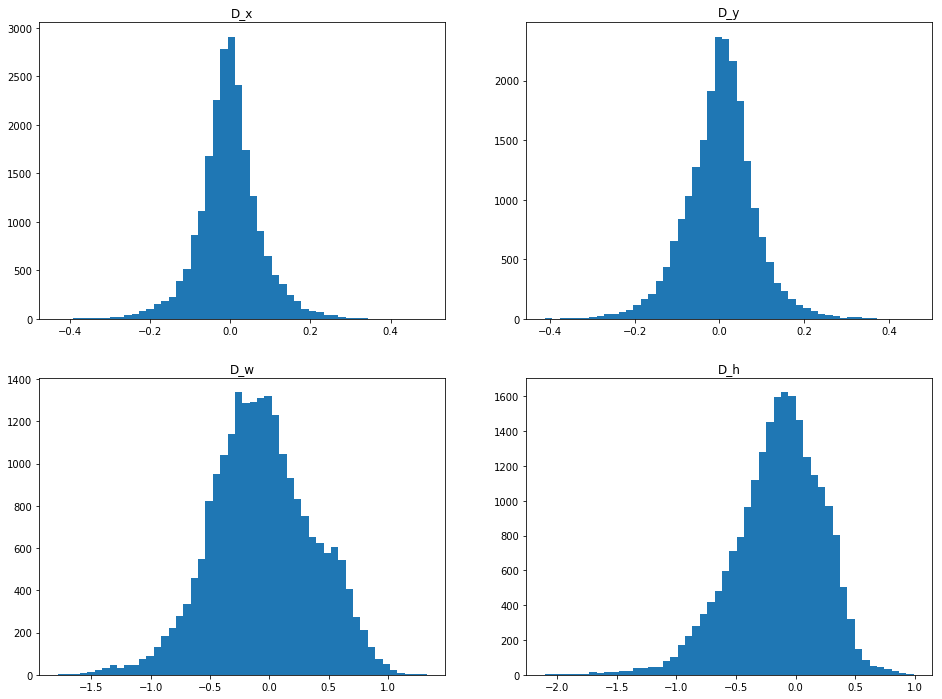

In [71]:
preds = rpn_bbox_pred.numpy()

_, axes = plt.subplots(2, 2, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    title = ['D_x', 'D_y', 'D_w', 'D_h'][idx]
    ax.set_title(title)
    ax.hist(preds[:, idx], bins=50)
    
plt.show()

Let's also plot the objectness scores. As you'll see, most of the anchors are deemed not worthy.

167 predictions over 0.9, out of a total of 22080



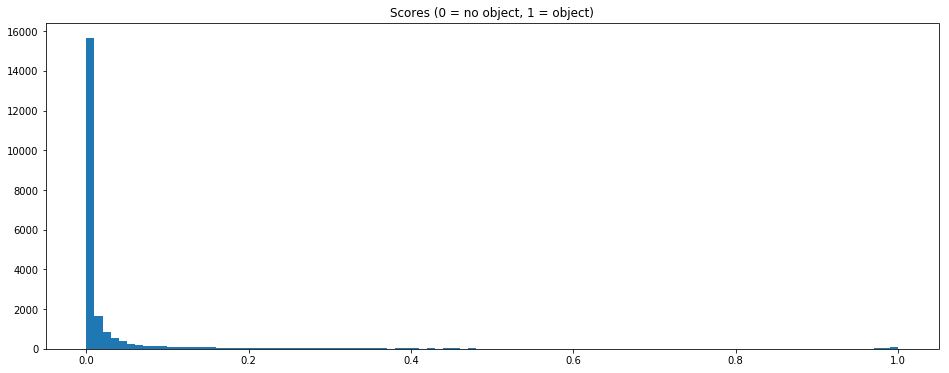

In [72]:
preds = rpn_cls_prob.numpy()[:, 1]

_, ax = plt.subplots(1, figsize=(16, 6))
ax.set_title('Scores (0 = no object, 1 = object)')
ax.hist(preds, bins=100)

print('{} predictions over 0.9, out of a total of {}'.format(
    len(np.flatnonzero(preds > 0.9)), len(preds)
))
print()
    
plt.show()

If you have some time left, it may prove insightful to analyze other statistics, such as the objectness and/or resizing by anchor size, or by position in the image. Performing an analysis like this can help pick hyperparameters, guide improvements for the algorithms and find pathologies on the architecture.

## Generating and filtering proposals

We now have the RPN layers outputs as-is. These will be the basis for *regions of interest* that will go through to the next stage of the object detection pipeline. We need, however, do a couple of things with them in order to get there:

* Remember that the RPN layers outputs are the **encoded deltas**. So we need to get them back to image pixel space.
* Some of the proposals may end up being invalid, as no constraints have been placed on the resizings (aside from the regularization induced by the encoding). For instance, we may end up with **zero-area proposals**, or with the extremes flipped. This may be especially true when we're training the algorithm from scratch, but we're going to filter them just in case.
* Finally, many of the proposals may end up being **very** similar to each other. Due to this, we're going to apply an operation called **non-maximum suppression** to filter out proposals that are very similar to each other.

Once this is done, we'll be free to continue to the next stage!

First we decode the outputs of the RPN using our previously-implemented `decode` function, obtaining **proposals**. We also get a single-dimension objectness score for each of these proposals.

In [73]:
# Generate proposals from the RPN's output by decoding the bounding boxes
# according to the configured anchors.
proposals = decode(anchors, rpn_bbox_pred)

# Get the (positive-object) scores from the RPN.
scores = tf.reshape(rpn_cls_prob[:, 1], [-1])

We then check and filter proposals that may have zero or negative area (negative area means, in this case, that the bounding box extremes were flipped). It is very much possible that, since we're using fully-trained weights, no proposals with negative area are present. You might want to see the `encode` and `decode` functions you implemented above to see exactly when it can go negative.

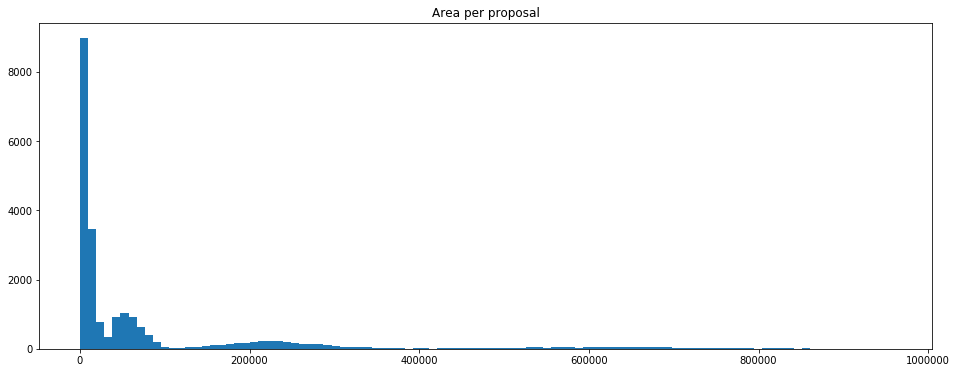

Proposals with areas under zero:
[]


In [74]:
props = proposals.numpy()
areas = (props[:, 2] - props[:, 0]) * (props[:, 3] - props[:, 1])

_, ax = plt.subplots(1, figsize=(16, 6))
ax.set_title('Area per proposal')
ax.hist(areas, bins=100)

plt.show()

print('Proposals with areas under zero:')
print(np.flatnonzero(areas <= 0))

In [75]:
# N.B.: You might as well skip this step if you're running out of time and
# there are no proposals with area under zero, but beware that on a real
# implementation ignoring this will cause trouble.

def filter_proposals(proposals, scores):
    """Filters non-positive area proposals.
    
    Arguments:
        proposals: Tensor of shape (num_proposals, 4), holding the
            coordinates of the proposals' bounding boxes.
        scores: Tensor of shape (num_proposals,), holding the
            scores associated to each bounding box.
        
    Returns:
        (`proposals`, `scores`), but with non-positive area proposals removed.
    """
    
    # See `tf.greater`, `tf.maximum`, `tf.boolean_mask`.
    
    ####
    # Fill this function below, paying attention to the docstring.
    ####

    (x_min, y_min, x_max, y_max) = tf.unstack(proposals, axis=1)
    zero_area_filter = tf.greater(
        tf.maximum(x_max - x_min, 0.0) * tf.maximum(y_max - y_min, 0.0),
        0.0
    )
    proposal_filter = zero_area_filter

    scores = tf.boolean_mask(
        scores, proposal_filter,
        name='filtered_scores'
    )
    proposals = tf.boolean_mask(
        proposals, proposal_filter,
        name='filtered_proposals'
    )
    
    ####

    return proposals, scores


# Filter proposals with negative areas.
proposals, scores = filter_proposals(proposals, scores)

Now we're going to use non-maximum suppression on the list of proposals we have. The end result will be a reduced list of proposals (in fact, of size `POST_NMS_TOP_N` defined below), ordered by objectness score, with some redundancy removed (that is, proposals that are too similar to each other will be discarded).

As explained in [1], NMS greedily selects a subset of bounding boxes in descending order of score, pruning away boxes that have high intersection-over-union (IOU) [2] overlap with previously selected boxes.

We'll be using `NMS_THRESHOLD` as the **IOU overlap threshold**. Also, in order to speed up the NMS (as we may have tens of thousands of proposals, depending on the image size), we'll first limit our proposal list to the top `PRE_NMS_TOP_N` proposals ordered by score.

We'll use an already-implemented Tensorflow function for NMS itself. While this avoids the need to code the algorithm, we need to prepare the parameters correctly to feed it.

You can read more about non-maximum suppression [here](https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/) and [here](https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/).

* [1] https://www.tensorflow.org/api_docs/python/tf/image/non_max_suppression
* [2] https://en.wikipedia.org/wiki/Jaccard_index

In [76]:
# Limit of the initial proposal list, to reduce the number of proposals fed to
# non-maximum suppression.
PRE_NMS_TOP_N = 12000


def keep_top_n(proposals, scores, topn):
    """Keeps only the top `topn` proposals, as ordered by score.
    
    Arguments:
        proposals: Tensor of shape (num_proposals, 4), holding the
            coordinates of the proposals' bounding boxes.
        scores: Tensor of shape (num_proposals,), holding the
            scores associated to each bounding box.
        topn (int): Number of proposals to keep.
        
    Returns:
        (`min(num_proposals, topn)`, `scores`) ordered by score.
    """

    # Tip: See `tf.minimum`, `tf.nn.top_k` to get the top values, and
    # `tf.gather` to select indices out of a Tensor.
    
    ####
    # Fill this function below, paying attention to the docstring.
    ####
    
    k = tf.minimum(topn, tf.shape(scores)[0])
    top_k = tf.nn.top_k(scores, k=k)

    sorted_top_proposals = tf.gather(proposals, top_k.indices)
    sorted_top_scores = top_k.values
    
    ####
    
    return sorted_top_proposals, sorted_top_scores


proposals, scores = keep_top_n(proposals, scores, PRE_NMS_TOP_N)

With the proposals pre-filtered, let's now apply NMS.

In [77]:
# Final maximum number of proposals, as returned by NMS.
POST_NMS_TOP_N = 2000

# IOU overlap threshold for the NMS procedure.
NMS_THRESHOLD = 0.7


# You might find the following function useful for re-ordening the coordinates
# as expected by Tensorflow.
def change_order(bboxes):
    """Change bounding box encoding order.

    Tensorflow works with the (y_min, x_min, y_max, x_max) order while we work
    with the (x_min, y_min, x_max, y_min).

    While both encoding options have its advantages and disadvantages we
    decided to use the (x_min, y_min, x_max, y_min), forcing us to switch to
    Tensorflow's every time we want to use function that handles bounding
    boxes.

    Arguments:
        bboxes: A Tensor of shape (total_bboxes, 4).

    Returns:
        bboxes: A Tensor of shape (total_bboxes, 4) with the order swaped.
    """
        
    ####
    # Fill this function below, paying attention to the docstring.
    ####
    
    first_min, second_min, first_max, second_max = tf.unstack(
        bboxes, axis=1
    )
    bboxes = tf.stack(
        [second_min, first_min, second_max, first_max], axis=1
    )
    
    ####
    
    return bboxes


def apply_nms(proposals, scores):
    """Applies non-maximum suppression to proposals.
    
    Arguments:
        proposals: Tensor of shape (num_proposals, 4), holding the
            coordinates of the proposals' bounding boxes.
        scores: Tensor of shape (num_proposals,), holding the
            scores associated to each bounding box.
        
    Returns:
        (`proposals`, `scores`), but with NMS applied, and ordered by score.
    """
    
    # Tip: See `tf.image.non_max_suppression` to perform NMS, our `change_order`
    # to prepare the bounding boxes, and `tf.gather` to pick indices out of a
    # Tensor.
    
    ####
    # Fill this function below, paying attention to the docstring.
    ####

    # We reorder the proposals into TensorFlows bounding box order
    # for `tf.image.non_max_suppression` compatibility.
    proposals_tf_order = change_order(proposals)
    
    # We apply NMS.
    selected_indices = tf.image.non_max_suppression(
        proposals_tf_order, tf.reshape(
            scores, [-1]
        ),
        POST_NMS_TOP_N, iou_threshold=NMS_THRESHOLD
    )

    # Selected_indices is a smaller tensor, we need to extract the
    # proposals and scores using it.
    proposals = tf.gather(proposals, selected_indices)
    scores = tf.gather(scores, selected_indices)

    ####

    return proposals, scores

pre_merge_proposals, pre_merge_scores = proposals, scores
proposals, scores = apply_nms(proposals, scores)

Let's check how the center positions have changed pre- and post- merging of proposals when restricted to the first $2000$ proposals. After applying NMS, we should have improved our coverage of the image somewhat.

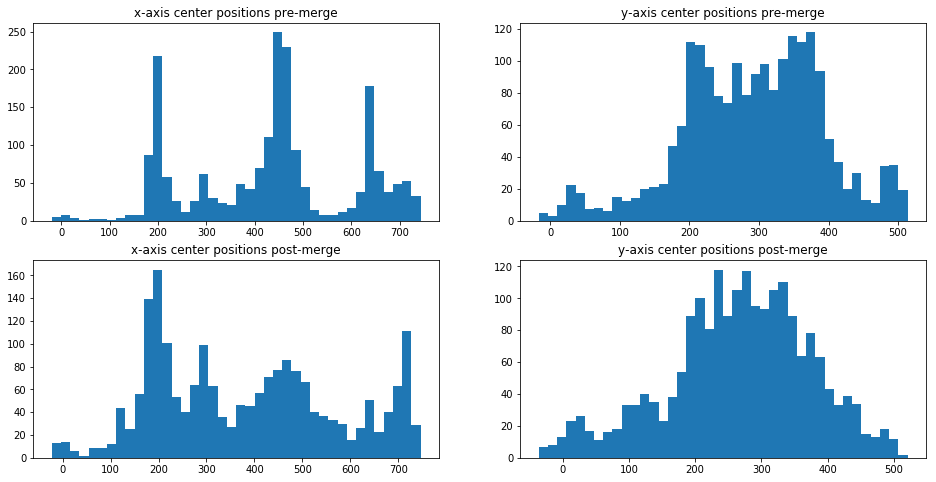

In [78]:
top_k = tf.nn.top_k(pre_merge_scores, k=proposals.shape[0])
props = tf.gather(pre_merge_proposals, top_k.indices).numpy()

pre_merge_centers = np.stack([
    (props[:, 0] + props[:, 2]) / 2,
    (props[:, 1] + props[:, 3]) / 2,
], axis=1)

post_merge_centers = np.stack([
    (proposals[:, 0] + proposals[:, 2]) / 2,
    (proposals[:, 1] + proposals[:, 3]) / 2,
], axis=1)

_, axes = plt.subplots(2, 2, figsize=(16, 8))
axes[0][0].set_title('x-axis center positions pre-merge')
axes[0][0].hist(pre_merge_centers[:, 0], bins=40)
axes[0][1].set_title('y-axis center positions pre-merge')
axes[0][1].hist(pre_merge_centers[:, 1], bins=40)
axes[1][0].set_title('x-axis center positions post-merge')
axes[1][0].hist(post_merge_centers[:, 0], bins=40)
axes[1][1].set_title('y-axis center positions post-merge')
axes[1][1].hist(post_merge_centers[:, 1], bins=40)

plt.show()

## Finishing up the RPN: what have we detected?

This concludes the work on the Region Proposal Network! We now have a mechanism to, given an image of arbitrary size, return **regions of interest** (i.e. proposals), where it looks like an object is present.

Having gone through all the steps, from generating anchors around the image to predicting and filtering proposals, we now have a list of `POST_NMS_TOP_N` proposals (two thousand, in this case), each with an objectness score assigned.

Two thousand proposals are, of course, many more than what we need. Also, we need to assign an actual class to each of these proposals, or discard them if they're not correct. That will be attacked by the rest of our object detection pipeline.

For now, let's take a look at our current results, so we can understand what we have to work with.

In [79]:
# Display the first `topn` proposals, as ordered by score.
@interact(
    nms=Checkbox(value=True, description='Apply NMS'),
    topn=pager(200, 1, min=1, value=10, description='Number of proposals')
)
def draw(nms, topn):
    if nms:
        p = proposals
        s = scores
    else:
        p = pre_merge_proposals
        s = pre_merge_scores
        
    print('Minimum score: {:.2f}'.format(s[topn]))
    return draw_bboxes(image, p[:topn])

interactive(children=(Checkbox(value=True, description='Apply NMS'), IntSlider(value=10, continuous_update=Fal…

---
# Standarizing proposals: Region of Interest Pooling

As we just said, we have obtained regions of interest for an arbitrarily-sized input image. Thousands of them. And all of them of a different size. As you've probably seen in the last visualization, some of them may be very small while others very big.

The objective of this stage is twofold:
* Get the proposals, defined in pixel-space coordinates, back to the feature maps.
* Get them all into a fixed size so they can later be fed into a fully-connected neural network.

This final size of each region of interest will be $7\times7\times1024$. $1024$ being the number of filters that our feature map has, while $7\times7$ corresponds to the common spatial size all proposals will have. (This implies, as you might notice, that the aspect ratio of the proposals will change.)

On the original Faster R-CNN paper, a technique called RoI pooling is used. Here, instead, we use the `tf.image.crop_and_resize` Tensorflow function, which is (in performance terms) almost equivalent but simpler to implement.

Also, bear in mind that the RoI pooling layer **first** resizes to *double* of the pooling size (i.e. gets regions of $14\times14$) and then uses max pooling to get the final $7\times7$ regions. This makes the resulting regions more smooth and makes them capture more details. One could even go further and resize to $28\times28$ or more, but since we're **making a copy** of the feature map, memory usage will rapidly go up.

So much for an introduction. The implementation should be relatively straightforward. So go on ahead!

In [80]:
def normalize_bboxes(proposals, im_shape):
    """
    Gets normalized coordinates for RoIs (between 0 and 1 for cropping)
    in TensorFlow's order (y1, x1, y2, x2).

    Arguments:
        roi_proposals: A Tensor with the bounding boxes of shape
            (total_proposals, 4), where the values for each proposal are
            (x_min, y_min, x_max, y_max).
        im_shape: A Tensor with the shape of the image (height, width).

    Returns:
        bboxes: A Tensor with normalized bounding boxes in TensorFlow's
            format order. Its should is (total_proposals, 4).
    """
    
    # See `tf.unstack`, `tf.stack`, `tf.cast`.
    
    ####
    # Fill this function below, paying attention to the docstring.
    ####

    im_shape = tf.cast(im_shape, tf.float32)

    x1, y1, x2, y2 = tf.unstack(
        proposals, axis=1
    )

    x1 = x1 / im_shape[1]
    y1 = y1 / im_shape[0]
    x2 = x2 / im_shape[1]
    y2 = y2 / im_shape[0]

    bboxes = tf.stack([y1, x1, y2, x2], axis=1)

    ####

    return bboxes



def roi_pooling(feature_map, proposals, im_shape, pool_size=7):
    """Perform RoI pooling.

    This is a simplified method than what's done in the paper that obtains
    similar results. We crop the proposal over the feature map and resize it
    bilinearly.
    
    This function first resizes to *double* of `pool_size` (i.e. gets
    regions of (pool_size * 2, pool_size * 2)) and then uses max pooling to
    get the final `(pool_size, pool_size)` regions.
    
    Arguments:
        feature_map: Tensor of shape (1, W, H, C), with WxH the spatial
            shape of the feature map and C the number of channels (1024
            in this case).
        proposals: Tensor of shape (total_proposals, 4), holding the proposals
            to perform RoI pooling on.
        im_shape: A Tensor with the shape of the image (height, width).
        pool_size (int): Final width/height of the pooled region.
    
    Returns:
        Pooled feature map, with shape `(num_proposals, pool_size, pool_size,
        feature_map_channels)`.
    """
    
    # Tip: See `tf.image.crop_and_resize` to get crops out of the feature map
    # and resize them. You can ignore the `box_ind` argument by passing an
    # array of the correct size filled with zeros (one per proposal).
    
    # Tip: Remember to perform the max pooling as described above, by using
    # the `tf.nn.max_pool` function.
    
    # N.B.: You can resize to `(pool_size, pool_size)` directly and avoid the
    # max pooling step, though the results *will* be inferior.
    
    ####
    # Fill this function below, paying attention to the docstring.
    ####

    # Get normalized bounding boxes.
    bboxes = normalize_bboxes(proposals, im_shape)
    bboxes_shape = tf.shape(bboxes)

    # Generate fake batch ids: since we're using a batch size of one, all the
    # `ids` for the bounding boxes are zero.
    batch_ids = tf.zeros((bboxes_shape[0],), dtype=tf.int32)

    # Apply crop and resize with extracting a crop double the desired size.
    crops = tf.image.crop_and_resize(
        feature_map, bboxes, batch_ids,
        [pool_size * 2, pool_size * 2],
    )

    # Applies max pool with [2,2] kernel to reduce the crops to half the
    # size, and thus having the desired output.
    pooled = tf.nn.max_pool(
        crops, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID'
    )

    ####

    return pooled


pooled = roi_pooling(feature_map, proposals, (image.shape[1], image.shape[2]))

In order to gain an intuition on what exactly is being done here, let's now visualize our **pooled regions of interest**, along with the image patches they come from.

In [81]:
pool = pooled.numpy()

# Pool the images too to visualize, but using a higher pooling size so
# we don't lose too much resolution.
image_crops = roi_pooling(
    image, proposals,
    (image.shape[1], image.shape[2]),
    pool_size=140
).numpy().astype(np.uint8)


@interact(
    fm_idx=pager(pool.shape[-1], 1, 'Feature map index'),
    im_idx=pager(pool.shape[0], 25, 'Proposals')
)
def display_pooled_proposal(fm_idx=0, im_idx=0):
    axes = image_grid(25, 5, sizes=(3, 3))
    
    for idx, ax in enumerate(axes):
        if im_idx * 25 + idx >= pool.shape[0]:
            break
            
        fm = (
            pool[idx, :, :, fm_idx]
            / pool[idx, :, :, fm_idx].max()
            * 255
        ).astype(np.uint8)
        
        # Get the pooled image regions.
        img = image_crops[im_idx * 25 + idx, ...]
        
        fm_image = Image.fromarray(fm, mode='L').convert('RGBA')
        fm_image = fm_image.resize(img.shape[0:2][::-1], resample=Image.NEAREST)

        # Add some alpha to overlay it over the image.
        fm_image.putalpha(120)

        base_image = Image.fromarray(img)
        base_image.paste(fm_image, (0, 0), fm_image)
        
        ax.imshow(base_image, aspect='auto')

    plt.subplots_adjust(wspace=.02, hspace=.02)
    plt.show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='Feature map index', layout=Layo…

---
# Using the proposals: Region-CNN

We're ready for the final stage! Here we'll be doing two things:
* Running our set of fixed-sized proposals through a network akin to what was done in the RPN: one input, two outputs. In this case, instead of an objectness score, the output will be a class score (plus a possible **background** score).
* Get these thousands of proposals into a reasonable number. We'll be performing NMS again, but this time per class.

As you can see, it looks like more of the same, which (save some details) it effectively is.

In [82]:
# We're finally ready to perform the classification, so load the class names.
with open('checkpoint/classes.json') as f:
    classes = json.load(f)
    
print(classes)

['airplane', 'apple', 'backpack', 'banana', 'baseball bat', 'baseball glove', 'bear', 'bed', 'bench', 'bicycle', 'bird', 'boat', 'book', 'bottle', 'bowl', 'broccoli', 'bus', 'cake', 'car', 'carrot', 'cat', 'cell phone', 'chair', 'clock', 'couch', 'cow', 'cup', 'dining table', 'dog', 'donut', 'elephant', 'fire hydrant', 'fork', 'frisbee', 'giraffe', 'hair drier', 'handbag', 'horse', 'hot dog', 'keyboard', 'kite', 'knife', 'laptop', 'microwave', 'motorcycle', 'mouse', 'orange', 'oven', 'parking meter', 'person', 'pizza', 'potted plant', 'refrigerator', 'remote', 'sandwich', 'scissors', 'sheep', 'sink', 'skateboard', 'skis', 'snowboard', 'spoon', 'sports ball', 'stop sign', 'suitcase', 'surfboard', 'teddy bear', 'tennis racket', 'tie', 'toaster', 'toilet', 'toothbrush', 'traffic light', 'train', 'truck', 'tv', 'umbrella', 'vase', 'wine glass', 'zebra']


## The classification network

As we mentioned before, this last stage will get the proposals through a fully-connected layer. However, before doing that, we'll perform a bit more feature extraction.

You might remember when you were implementing the RPN that we used the first three out of four blocks of the ResNet for feature extraction, discarding the final block. The reasoning behind this move was to leverage the fact that the block three should, in principle, detect more *abstract features* than the final, block four. Now we're ready to perform the final classification, so we will first pass our proposals (which are cuts, although resized, of the original feature map) through **the block four of the ResNet**.

Also, once we do this, since we've already extracted all the features we care about, we'll perform **Global Average Pooling** which means, essentialy, to average out the spatial information: we only care that in a given proposal, some feature was present all around. That means we'll be left with a single $1024$-sized vector per proposals.

And, finally, pass this fixed-length vector through two fully-connected layers: one for the bounding box resizings and one for the classes. Since we've used the block four of the ResNet already, we'll not be using an intermediate layer.

In [83]:
print(run_resnet_tail.__doc__)

Pass `inputs` through the last block of the Resnet.

    Arguments:
        inputs: Tensor of shape (total_proposals, pool_size, pool_size, 1024),
            the result of the RoI pooling layer.

    Returns:
        Tensor of shape (total_proposals, pool_size, pool_size, 2048), with the
        output of the final block.
    


In [84]:
def run_rcnn(pooled, num_classes):
    """Run the RCNN layers through the pooled features.

    This directly applies a fully-connected layer from `features`
    to the two outputs we want: a class probability (plus the
    background class) and the bounding box resizings (one per
    class).
    
    In order to obtain the class probability, we apply a softmax
    over the scores obtained from the dense layer, similar to the RPN.
    
    Arguments:
        pooled: Pooled feature map, with shape `(num_proposals,
            pool_size, pool_size, feature_map_channels)`.
        num_classes: Number of classes for the R-CNN.
            
    Returns:
        Tuple of Tensors, with the first being the output of the
        bbox resizings `(W * H * proposals, 4)` and the second being
        the class scores, of size `(pool_size ^ 2 * proposals,
        num_classes)`.
    """
    
    # Remember, you need to do three things with `pooled`:
    # * Pass them through the ResNet block four.
    #   (Tip: See the function `run_resnet_tail`s docstring above.)
    # * Perform Global Average Pooling.
    #   (Tip: See the function `tf.reduce_mean`.)
    # * Run them through two fully-connected layers.
    #   (Tip: See the functions `tf.layers.dense`, `tf.nn.softmax`.)
    
    # W.r.t the fully-connected layers, remember:
    # * To add an extra class for the background class.
    # * To have bounding-box resizings **per-class**.
    
    # The names of the layers should be: `rcnn/fc_classifier` for
    # the classification head, and `rcnn/fc_bbox` for the bbox
    # resizing head.
    
    ####
    # Fill this function below, paying attention to the docstring.
    ####
    features = run_resnet_tail(pooled)
    
    features = tf.reduce_mean(features, [1, 2])
    
    rcnn_cls_score = tf.layers.dense(
        features,
        num_classes + 1,
        name='rcnn/fc_classifier',
    )

    rcnn_cls_prob = tf.nn.softmax(rcnn_cls_score)

    rcnn_bbox = tf.layers.dense(
        features,
        num_classes * 4,
        name='rcnn/fc_bbox',
    )
    ####

    return rcnn_bbox, rcnn_cls_prob


with tfe.restore_variables_on_create('checkpoint/fasterrcnn'):
    bbox_pred, cls_prob = run_rcnn(pooled, len(classes))
    
    
assert bbox_pred.shape[0] == pooled.shape[0], 'Number of proposals should match'
assert cls_prob.shape[0] == pooled.shape[0], 'Number of proposals should match'

assert bbox_pred.shape[1] == len(classes) * 4, 'There should be 4 bbox resizings per class'
assert cls_prob.shape[1] == len(classes) + 1, 'There should be 81 class probabilities (remember the background!)'

Let's take a look at the results now, and see whether they make sense.

We'll display the **most probable class for each proposal**, before applying the final class-specific resizing: this is the pooled region of interest, what the classifier actually looked at.

In [85]:
output_classes = ['background'] + classes
    
preds = np.argmax(cls_prob.numpy(), axis=1)

@interact(page=pager(len(preds), 20, 'Proposals'))
def display_predictions(page):
    axes = image_grid(20, 5, sizes=(3, 3))
    
    for idx, ax in enumerate(axes):
        if 20 * page + idx >= image_crops.shape[0]:
            break
            
        ax.imshow(image_crops[20 * page + idx, ...], aspect='auto')
        ax.set_title(output_classes[preds[20 * page + idx]])

    plt.subplots_adjust(wspace=.02, hspace=.15)
    plt.show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='Proposals', layout=Layout(width…

We'll now display the proposals again, but with the **bounding box resizings applied**.

Corrections are done per-class. In order to understand how much these predictions vary, we take some proposals and apply the different possible resizings.

For each region, we first display the resizing for the most probable class and then for three other random classes. If the most probable class is background, we ignore it.

Do you notice anything in particular? Which resizing is the one that fits better to the detected object?

In [86]:
# Target normalization variances to adjust the output of the R-CNN so it trains better.
TARGET_VARIANCES = np.array([0.1, 0.1, 0.2, 0.2], dtype=np.float32)

# We only consider proposals for which the most-probable class was non-background.
preds = np.argmax(cls_prob.numpy(), axis=1)
non_background = (preds != 0)

non_bg_preds = preds[non_background]
non_bg_proposals = proposals.numpy()[non_background]
non_bg_bboxes = bbox_pred.numpy()[non_background]
non_bg_count = len(np.flatnonzero(non_background))


@interact(page=pager(non_bg_count, 3, 'Proposals'))
def display_resizings(page):
    _, axes = plt.subplots(3, 5, figsize=(16, 10))
    
    for row_idx, cols in enumerate(axes):
        for col in cols:
            col.axis('off')

        proposal_idx = 3 * page + row_idx    
        if proposal_idx >= non_bg_count:
            continue
        
        # Original region.
        # (Using original region size so comparison is easier to the eye.)
        x_min, y_min, x_max, y_max = clip_boxes(
            non_bg_proposals[proposal_idx:proposal_idx + 1],
            image.shape[1:3]
        )[0].numpy().astype(np.int)
        cols[0].imshow(image[0, y_min:y_max, x_min:x_max, :])
        cols[0].set_title('Region')
        
        # Per-class region, correct class first.
        class_ids = np.concatenate([
            np.array([non_bg_preds[proposal_idx] - 1]),
            np.random.randint(0, len(classes), 3)
        ])
        for col, class_id in zip(cols[1:], class_ids):
            cls_bbox_pred = non_bg_bboxes[
                proposal_idx:proposal_idx + 1,
                (4 * class_id):(4 * class_id + 4)
            ]

            cls_objects = decode(
                non_bg_proposals[proposal_idx:proposal_idx+1],
                cls_bbox_pred * TARGET_VARIANCES
            ).numpy()
            
            x_min, y_min, x_max, y_max = clip_boxes(
                cls_objects, image.shape[1:3]
            )[0].numpy().astype(np.int)

            col.imshow(image[0, y_min:y_max, x_min:x_max, :])
            col.set_title(classes[class_id])
        
    plt.subplots_adjust(wspace=.02, hspace=.15)
    plt.show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='Proposals', layout=Layout(width…

## Filtering the object proposals

We're finally getting there! We have one last step to do: getting the final predictions.

What we have now is a list of `POST_NMS_TOP_N` proposals (around $2000$), each with 81 class scores (80 classes plus the background) and 80 bounding box resizings. Out of this, we'll consider a total of $2000 \times 80 = 160000$ proposals, each with a **score** (its class score) and **bounding box resizing**. We do this in order to consider **all** possible classifications for a given bounding box: if the most-probable class of a bounding box has a score of $0.48$ and the second one has a score of $0.47$, it is important to consider **both** variants, and not just the highest-scored one.

Of course, we'll not really build the $160000$ proposals at once, but instead perform NMS **on a class-by-class basis**, keeping only the top $100$ proposals per class. Then we'll order all the proposals and keep only the top $300$, which will be the output of our algorithm.

**We've already implemented all this part for you**, as it's same as above but on a class-by-class basis. With a little work, you should be able to do it by yourself if you want.

In [87]:
objects, labels, probs = rcnn_proposals(
    proposals, bbox_pred, cls_prob, image.shape[1:3], 80,
    min_prob_threshold=0.0,
)

objects = objects.numpy()
labels = labels.numpy()
probs = probs.numpy()

Number of detections above 0.1 probability: 10
Number of detections above 0.5 probability: 5
Number of detections above 0.7 probability: 2

Top 5 predicted classes:
   49: person (1.69)
   36: handbag (1.62)
   9: bicycle (1.06)
   72: traffic light (0.80)
   2: backpack (0.63)


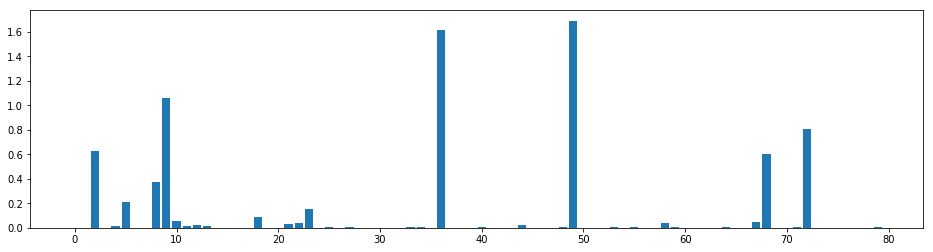

In [88]:
print('Number of detections above 0.1 probability:', len(labels[probs > 0.1]))
print('Number of detections above 0.5 probability:', len(labels[probs > 0.5]))
print('Number of detections above 0.7 probability:', len(labels[probs > 0.7]))
print()

# Accumluated probability score per class.
probs_per_class = np.bincount(labels, weights=probs, minlength=len(classes))
top_n = probs_per_class.argsort()[::-1][:5]
print('Top 5 predicted classes:')
for cls_idx in top_n:
    print('   {}: {} ({:.2f})'.format(cls_idx, classes[cls_idx], probs_per_class[cls_idx]))
    
_, ax = plt.subplots(1, figsize=(16, 4))
ax.bar(np.arange(80), probs_per_class)

plt.show()

At the end of the day, however, we don't want $300$ low-quality detections, but whatever is good. What we do in practice is to filter detections by their probability score (which is the proposal's class score).

Let's take a look at the $300$ proposals and see how much the predictions change when filtering by score. In the real world, you'll probably use a threshold above $0.5$, depending on your desired precision vs. recall trade-off (too high a threshold will miss detections, while too low will add noise).

In [89]:
slider = FloatSlider(
    min=0.0, max=1.0, step=0.01, value=0.7,
    description='Probability threshold',
    layout=Layout(width='600px'),
    style={'description_width': 'initial'},
    continuous_update=False
)

@interact(prob=slider)
def display_objects(prob):
    MAX_TO_DRAW = 50

    mask = probs > prob

    return draw_bboxes_with_labels(
        image, classes,
        objects[mask][:MAX_TO_DRAW],
        labels[mask][:MAX_TO_DRAW],
        probs[mask][:MAX_TO_DRAW],
    )

interactive(children=(FloatSlider(value=0.7, continuous_update=False, description='Probability threshold', lay…

---
# Summing up

**Congratulations!** You finished your own implementation of Faster R-CNN, one of the state-of-the-art object detection algorithms.

Throughout this notebook you should have learned quite a few things:
* **How modern object detectors work**: what inputs they take, what kinds of operations and logic they do, and how much control we have in their workings.
* In particular, **how Faster R-CNN works**, very much in depth.
* **How to use Tensorflow and numpy in the context of computer vision and object detection**. Going a bit more than the usual "stack three layers and call it a day": we've worked with arbitrarily-sized inputs, used conditionals, filtering and other non-standard functions, all within the Tensorflow graph (meaning it can run entirely within a GPU).
* **How to visualize the inner workings of an object detection pipeline**. By leveraging an already-trained network, we could see and corroborate each step of the pipeline to understand what goes behind the scenes and whether we made any errors. This process may have also given you some clues in how to improve the algorithm itself.

This, of course, is just the beginning. Some things you could try, going forward, are:
* **Implement the training of a Faster R-CNN model**. We barely touched on this part, using a pre-trained checkpoint provided by us. The training, apart from using the autograd of your favorite deep learning library, requires some extra steps:

    * Implement the **targets**. We're using supervised learning to train this, so how does training data fit into this? We need to train both the RPN and the R-CNN. In order to do this, we need to build mini-batches of training data for both components, by matching ground-truth boxes to our proposals. You can learn how this is done in our implementation of [Luminoth](https://github.com/tryolabs/luminoth).

    * Implement the **loss functions**. Once the targets are in place, we need to select good losses and balance our dataset in order to train correctly. There may be some difficulties when training, as we are optimizing four losses in total (two for the RPN, two for the R-CNN).

* Improve the algorithm itself. Faster-RCNN has been out for a while now, and while it's still very competitive, there are some known improvements to do. For instance, the RPN can be replaced entirely with the **Feature Pyramid Network** (FPN) [1] and the loss exchanged with the **Focal Loss** [2], to obtain the algorithm called **RetinaNet**.


* [1] https://arxiv.org/pdf/1612.03144.pdf
* [2] https://arxiv.org/pdf/1708.02002.pdf